In [1]:
import numpy as np
import cv2
import imutils

from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage

from skimage import io
from matplotlib import pyplot as plt
from PIL import ImageEnhance, Image

from utils import cv2_imshow

In [2]:
[c1, c2, c3, c4,c5,c6,c7,c8,c9,c10,c11,c12] = [cv2.imread(f'images/count{i}.jpg') for i in range(1,13)]


In [3]:
def threshold(image, t=0, maxVal=255, style=cv2.THRESH_OTSU):
    shifted = cv2.pyrMeanShiftFiltering(image, 21, 51)
    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray,t, maxVal, style)[1]
    return thresh

def adaptive_threshold(image, *threshold_args):
    shifted = cv2.pyrMeanShiftFiltering(image, 21, 51)
    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(gray, *threshold_args)
    return thresh

In [4]:
def count_watershed(image, min_distance=10, min_radius=0, max_radius=1000, thresh=None, circle=True):
    image = image.copy()
    shifted = cv2.pyrMeanShiftFiltering(image, 21, 51)
    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
    if thresh is None:
        thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)[1]
    cv2_imshow(thresh)
    
    D = ndimage.distance_transform_edt(thresh)
    localMax = peak_local_max(D, indices=False, min_distance=min_distance, labels=thresh)

    markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
    labels = watershed(-D, markers, mask=thresh)
    objects = 0
    
    for label in np.unique(labels):
        if label == 0:
            continue

        mask = np.zeros(gray.shape, dtype="uint8")
        mask[labels == label] = 255

        cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)
        ((x, y), r) = cv2.minEnclosingCircle(c)
        if r >= min_radius and r <= max_radius:
            if circle:
                cv2.circle(image, (int(x), int(y)), int(r), (0, 255, 0), 1)
            else:
                cv2.drawContours(image, [c], -1, (0, 255, 0), 1)
            objects += 1
    cv2_imshow(image)
    print(f"Found {objects} objects")


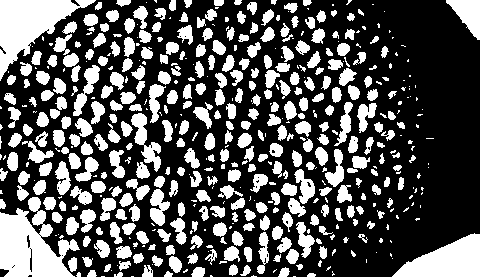

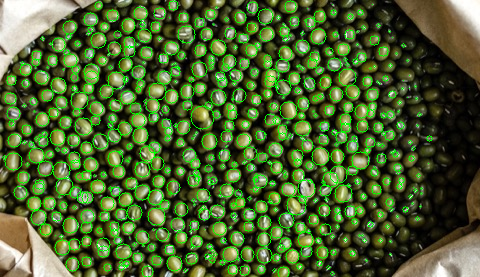

Found 586 objects


In [5]:
count_watershed(c1, 3, 0.5, 25)

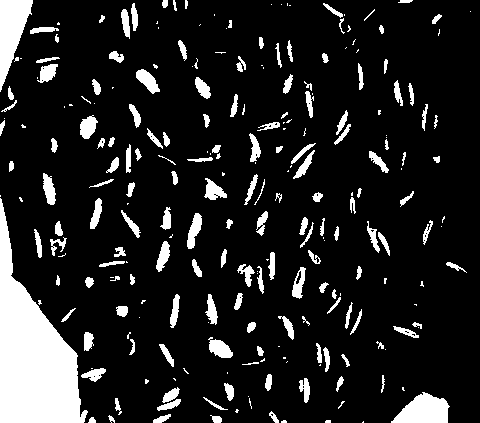

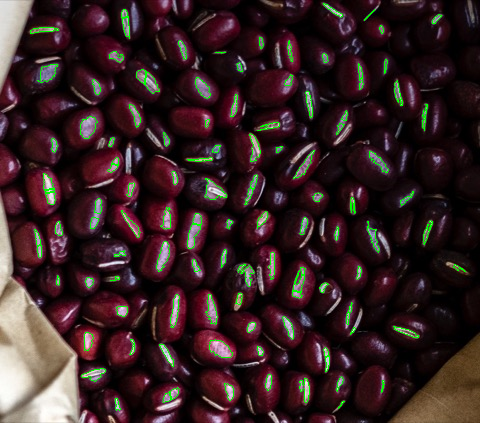

Found 114 objects


In [6]:
count_watershed(c2, 15, 4, 30, circle=False)

Original:


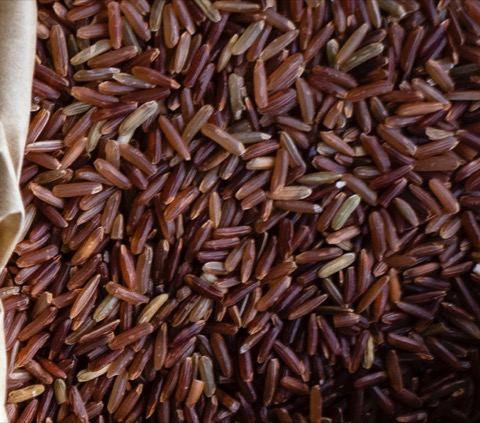

Adjusted:


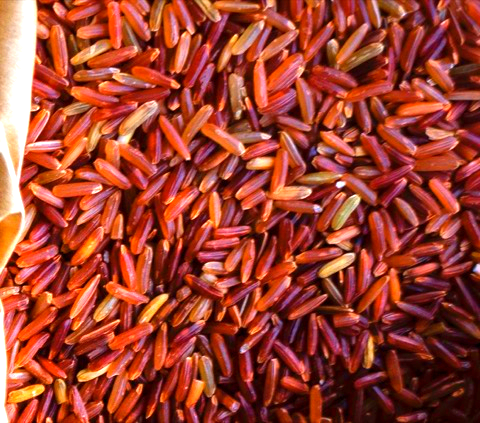

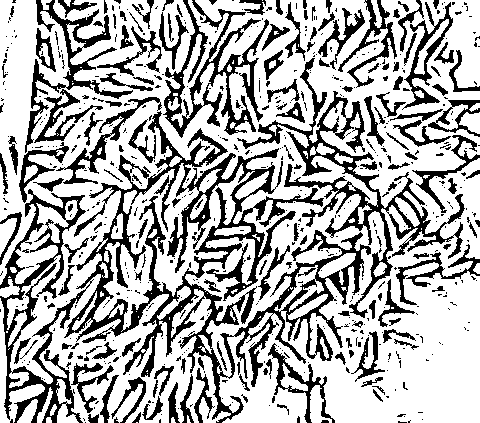

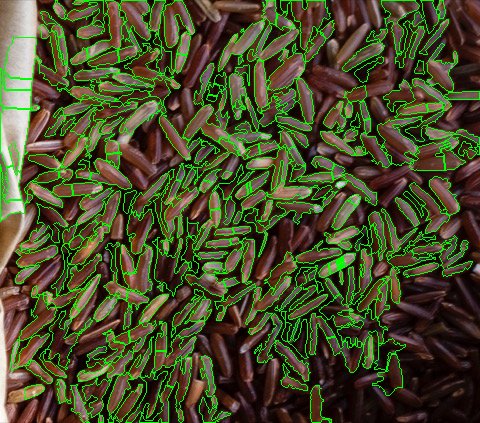

Found 236 objects


In [7]:
print('Original:')
cv2_imshow(c3)
c3_bright = ImageEnhance.Brightness(Image.fromarray(c3)).enhance(1.3)
c3_color = ImageEnhance.Color(c3_bright).enhance(1.2)
c3_contrast = ImageEnhance.Color(c3_color).enhance(2)
c3_adjusted = np.array(c3_contrast)
print('Adjusted:')
cv2_imshow(c3_adjusted)
c3_thresh = adaptive_threshold(
    c3_adjusted, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 11
)
count_watershed(c3, 12, 5, 35, thresh=c3_thresh, circle=False)

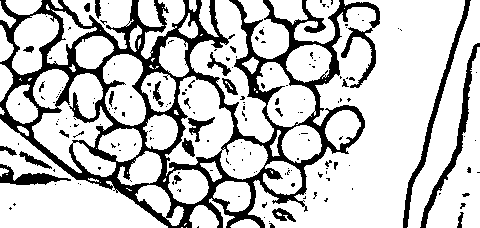

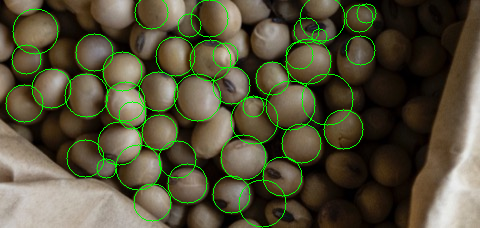

Found 45 objects


In [8]:
c4_thresh = adaptive_threshold(
    c4, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 3
)
count_watershed(c4, 13, 3, 28, thresh=c4_thresh)

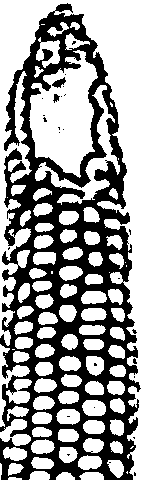

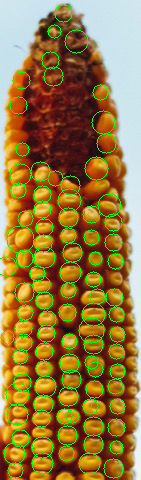

Found 95 objects


In [9]:
c5_thresh = adaptive_threshold(
    c5, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, 3
)
count_watershed(c5, 7, 7.5, 15, thresh=c5_thresh)

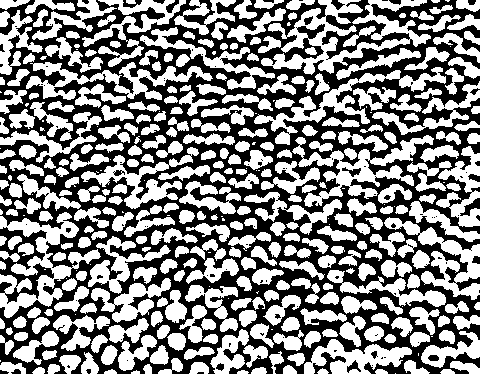

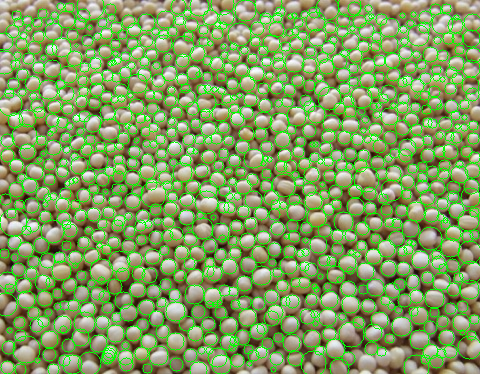

Found 909 objects


In [10]:
c6_thresh = adaptive_threshold(
    c6, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, 3
)
count_watershed(c6, 5, 2, 15, thresh=c6_thresh)

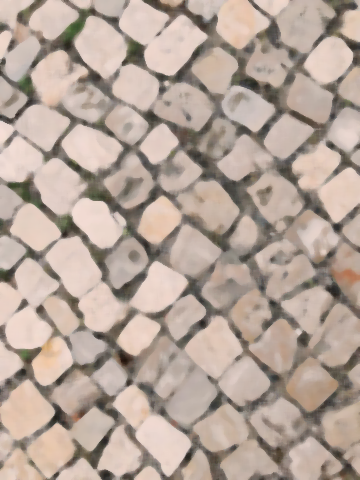

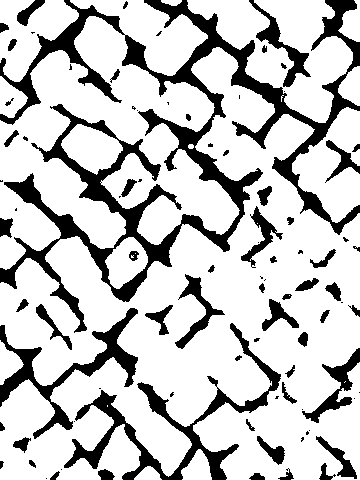

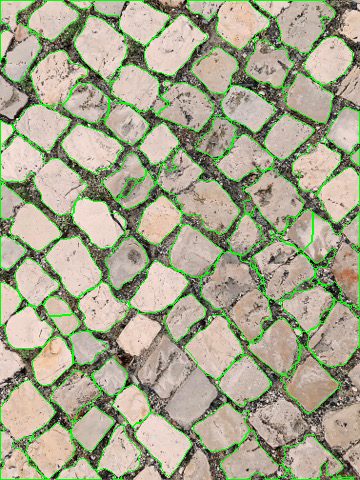

Found 66 objects


In [11]:
c7_blurred = cv2.medianBlur(c7, 7)
cv2_imshow(c7_blurred)
c7_thresh = adaptive_threshold(
    c7_blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 41, 30
)
count_watershed(c7, 17, 8, 60, thresh=c7_thresh, circle=False)

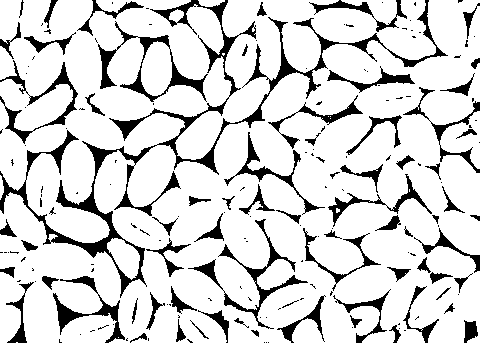

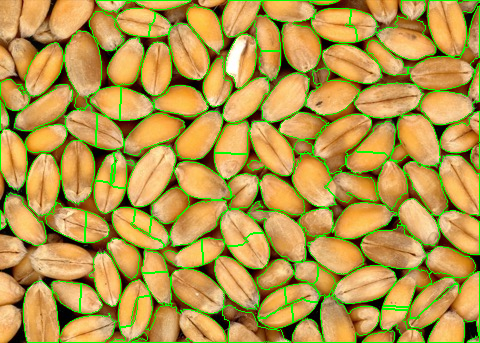

Found 107 objects


In [12]:
c8_thresh = adaptive_threshold(
    c8, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 35
)
count_watershed(c8, 13, 7, 60, circle=False, thresh=c8_thresh)

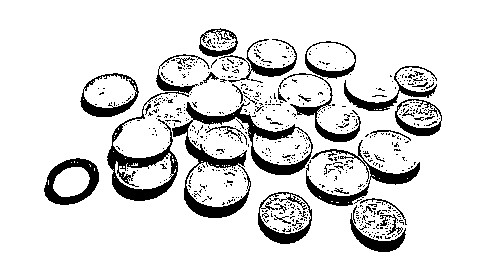

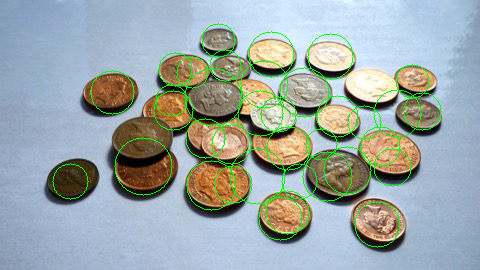

Found 36 objects


In [13]:
c9_1 = c9.copy()
c9_1[:,:,0] = 0

kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
c9_sharpen = cv2.filter2D(c9_1, -1, kernel)

c9_thresh = adaptive_threshold(
    c9_sharpen, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 31, 32
)

count_watershed(c9, 12, 16, 30, thresh=c9_thresh)

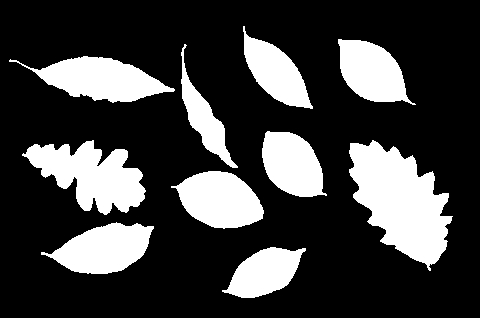

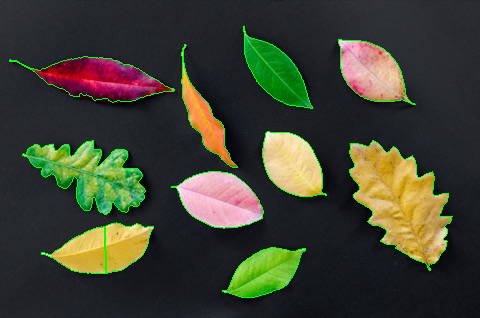

Found 11 objects


In [14]:
c10_bright = ImageEnhance.Brightness(Image.fromarray(c10)).enhance(1.5)
c10_color = ImageEnhance.Color(c10_bright).enhance(2)
c10_contrast = ImageEnhance.Color(c10_color).enhance(2)

c10_adjusted = np.array(c10_contrast)
c10_thresh = threshold(c10_adjusted, 75, maxVal=255, style=cv2.THRESH_BINARY)

count_watershed(c10, 30, 20, 160, circle=False, thresh=c10_thresh)

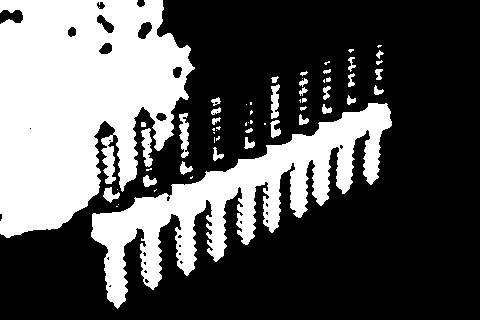

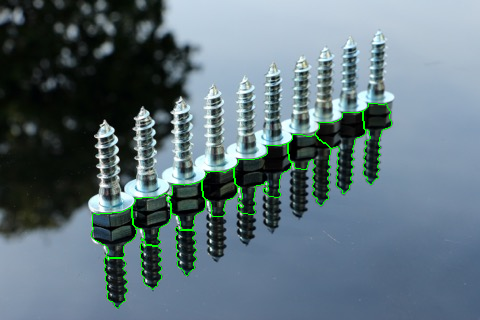

Found 11 objects


In [15]:
c11_blur = cv2.medianBlur(c11, 3)
c11_thresh = threshold(c11_blur, 90, maxVal=255, style=cv2.THRESH_BINARY_INV)

count_watershed(c11, 22, 20, 50, circle=False, thresh=c11_thresh)

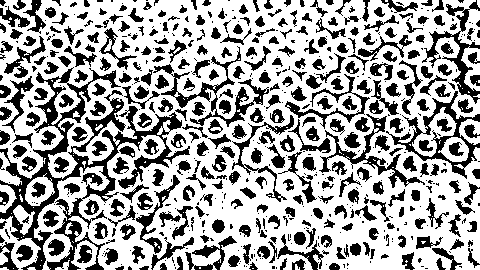

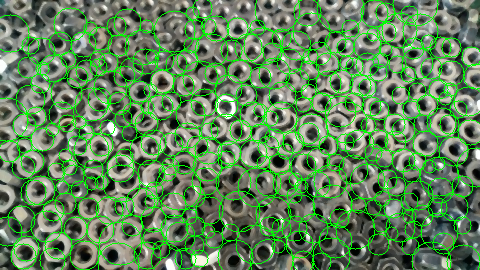

Found 317 objects


In [16]:
c12_blurred = cv2.medianBlur(c12, 3)
c12_thresh = adaptive_threshold(
    c12, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 13, 12
)
count_watershed(c12_blurred, 9, 7, 25, thresh=c12_thresh)